In [4]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, classification_report


In [5]:
MODEL_PATH = "../models/nepali_mobilenetv2.pth"
DATA_DIR = "clusteredData"
IMAGE_SIZE = 224
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg")

sns.set_style("whitegrid")


In [6]:
# Load model and class names
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
class_names = checkpoint["class_names"]
num_classes = len(class_names)

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.last_channel, num_classes)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE)
model.eval()

print("Model loaded successfully.")


Model loaded successfully.


/Users/nishanrana/Final_Project /Nepali_digit_reconigation/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nishanrana/Final_Project /Nepali_digit_reconigation/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_dataset = datasets.ImageFolder(DATA_DIR, transform=val_transforms)

# 20% validation split
val_size = int(0.2 * len(full_dataset))
_, val_dataset = torch.utils.data.random_split(full_dataset, [len(full_dataset)-val_size, val_size])
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Validation samples: {len(val_dataset)}")


Validation samples: 1057


In [8]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)


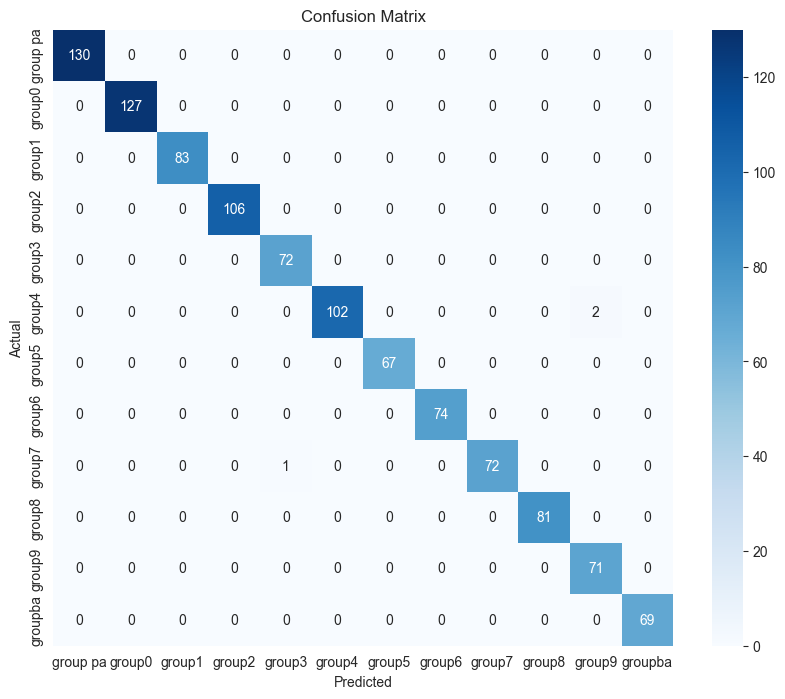

In [9]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [10]:
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

    group pa       1.00      1.00      1.00       130
      group0       1.00      1.00      1.00       127
      group1       1.00      1.00      1.00        83
      group2       1.00      1.00      1.00       106
      group3       0.99      1.00      0.99        72
      group4       1.00      0.98      0.99       104
      group5       1.00      1.00      1.00        67
      group6       1.00      1.00      1.00        74
      group7       1.00      0.99      0.99        73
      group8       1.00      1.00      1.00        81
      group9       0.97      1.00      0.99        71
     groupba       1.00      1.00      1.00        69

    accuracy                           1.00      1057
   macro avg       1.00      1.00      1.00      1057
weighted avg       1.00      1.00      1.00      1057



Total misclassified: 3


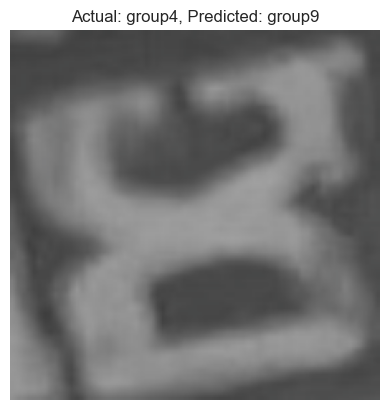

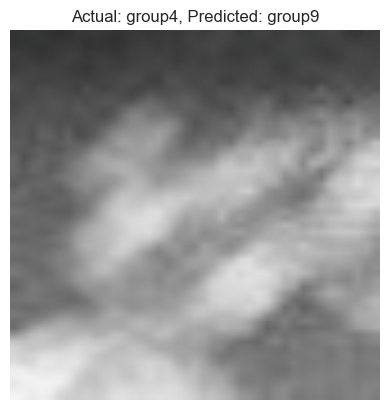

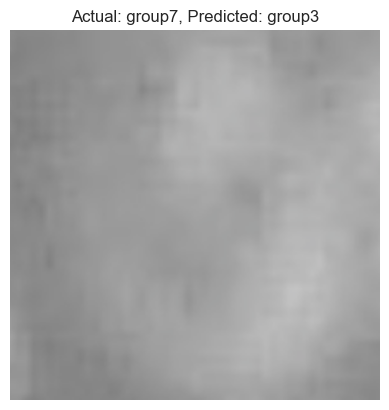

In [11]:
misclassified_idx = np.where(all_labels != all_preds)[0]

print(f"Total misclassified: {len(misclassified_idx)}")

for idx in misclassified_idx[:10]:  # show first 10
    img_path, label_idx = val_dataset[idx][0], val_dataset[idx][1]
    img = val_dataset[idx][0].permute(1,2,0).numpy()
    img = (img * [0.229,0.224,0.225]) + [0.485,0.456,0.406]  # denormalize
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title(f"Actual: {class_names[all_labels[idx]]}, Predicted: {class_names[all_preds[idx]]}")
    plt.axis("off")
    plt.show()
